<a href="https://colab.research.google.com/github/Chiaoso/Chiaoso/blob/main/ASR_adversarial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Teacher Training Workshop

## Hands-on Machine Learning Course: Adversarial Attacks Against ASR Systems



## Step 1: Preparation

1. Runtime, Factory reset runtime
2. Runtime, Change runtime type, Hardware accelerator: GPU

## Step 1.1: Install and Import Library

In [ ]:
# Install datasets and other libraries
!pip install -U -q tensorflow tensorflow_datasets
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

# Import library
import os
import pathlib
import glob
import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 20 not upgraded.
Need to get 430 MB of archives.
After this operation, 1,153 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 9s (49.4 MB/s)
(Reading database ... 128275 files and directories currently installed.)
Removing libcudnn8-dev (8.7.0.84-1+cuda11.8) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
dpkg: warning: downgrading libcudnn8 from 8.7.0.84-1+cuda11.8 to 8.1.0.77-1+cuda11.2
(Reading database ... 128242 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.0.7

In [ ]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182082353/182082353 [==============================] - 1s 0us/step


The dataset's audio clips are stored in eight folders corresponding to each speech command: `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`:

In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['down' 'left' 'right' 'stop' 'up' 'no' 'go' 'yes']


Divided into directories this way, you can easily load the data using `keras.utils.audio_dataset_from_directory`. 

The audio clips are 1 second or less at 16kHz. The `output_sequence_length=16000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [ ]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`. 

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [ ]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd keep it in a separate directory, but in this case you can use `Dataset.shard` to split the validation set into two halves. Note that iterating over **any** shard will load **all** the data, and only keep its fraction. 

In [ ]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [ ]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


Let's plot a few audio waveforms:

In [ ]:
label_names[[1,1,3,0]]

array(['go', 'go', 'no', 'down'], dtype='<U5')

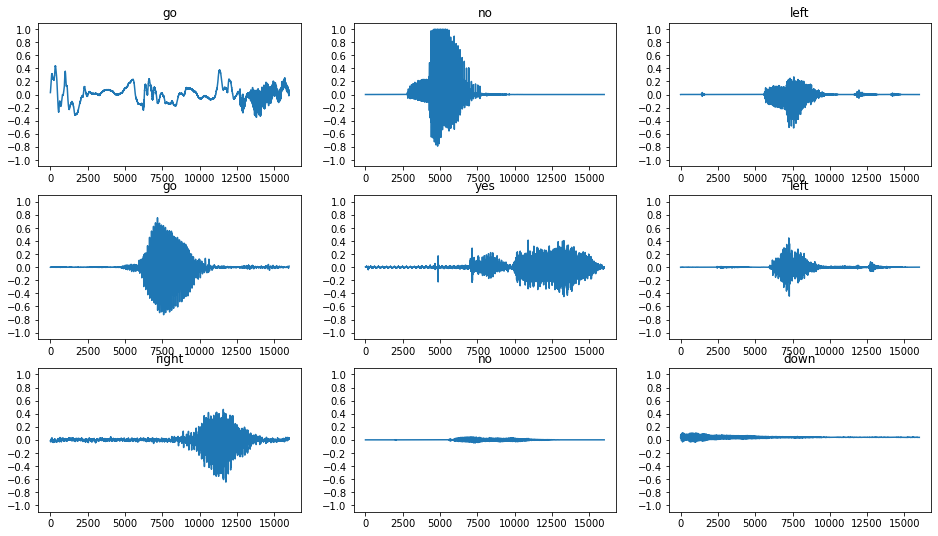

In [ ]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(example_audio[i].numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label_names[example_labels[i]]
  ax.set_title(label)
  ax.set_ylim([-1.1,1.1])

plt.show()

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [ ]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  # print("waveform_dtype:" + str(waveform.dtype))
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # print("original_spectrogram_dtype:" + str(spectrogram.dtype))
  # print("original_spectrogram_shape:" + str(spectrogram.shape))
  wave = tf.signal.inverse_stft(spectrogram, frame_length=255, frame_step=128, window_fn=tf.signal.inverse_stft_window_fn(128))
  # print("wave_dtype:"+str(wave.dtype))
  # print("wave_shape:"+str(wave.shape))
  # Obtain the magnitude of the STFT.
  # spectrogram = tf.abs(spectrogram)
  # print("spectrogram_dtype:" + str(spectrogram.dtype))
  # print("spectrogram_shape:" + str(spectrogram.shape))
  wave_from_cast = tf.signal.inverse_stft(tf.cast(spectrogram, tf.complex64), frame_length=255, frame_step=128, window_fn=tf.signal.inverse_stft_window_fn(128))
  # print("wave_cast_dtype:"+str(wave_from_cast.dtype))
  # print("wave_cast_shape:"+str(wave_from_cast.shape))
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [ ]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)
  

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [ ]:
def plot_spectrogram(spectrogram, ax):
  spec = tf.abs(spectrogram)
  if len(spec.shape) > 2:
    assert len(spec.shape) == 3
    spec = np.squeeze(spec, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spec.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spec), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

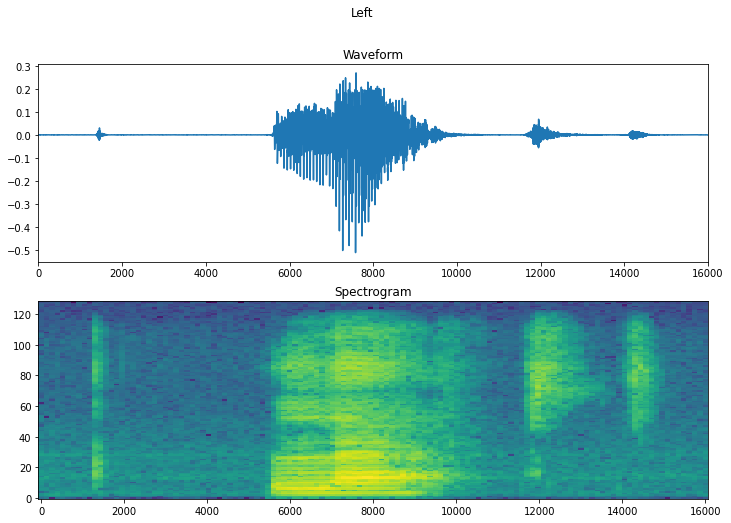

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram, axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogramn datasets from the audio datasets:

In [ ]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Examine the spectrograms for different examples of the dataset:

In [ ]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

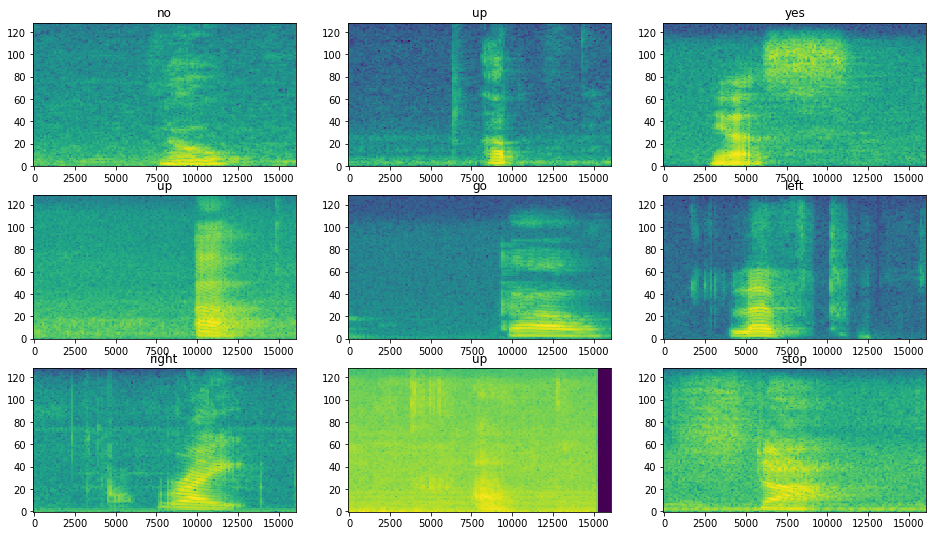

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Build and train the model

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [ ]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [ ]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels,activation='softmax'),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train the model over 10 epochs for demonstration purposes:

In [ ]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


100/100 [==============================] - 6s 24ms/step - loss: 1.8850 - accuracy: 0.3102 - val_loss: 1.6612 - val_accuracy: 0.4570
Epoch 2/10
100/100 [==============================] - 1s 8ms/step - loss: 1.6026 - accuracy: 0.4308 - val_loss: 1.5072 - val_accuracy: 0.5208
Epoch 3/10
100/100 [==============================] - 1s 8ms/step - loss: 1.3800 - accuracy: 0.5039 - val_loss: 1.3300 - val_accuracy: 0.5521
Epoch 4/10
100/100 [==============================] - 1s 9ms/step - loss: 1.2127 - accuracy: 0.5602 - val_loss: 1.2623 - val_accuracy: 0.5677
Epoch 5/10
100/100 [==============================] - 1s 9ms/step - loss: 1.0775 - accuracy: 0.6111 - val_loss: 1.1837 - val_accuracy: 0.6263
Epoch 6/10
100/100 [==============================] - 1s 9ms/step - loss: 0.9625 - accuracy: 0.6467 - val_loss: 1.1955 - val_accuracy: 0.5990
Epoch 7/10
100/100 [==============================] - 1s 8ms/step - loss: 0.8577 - accuracy: 0.6864 - val_loss: 1.1357 - val_accuracy: 0.6120
Epoch 8/10
100/1

Let's plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

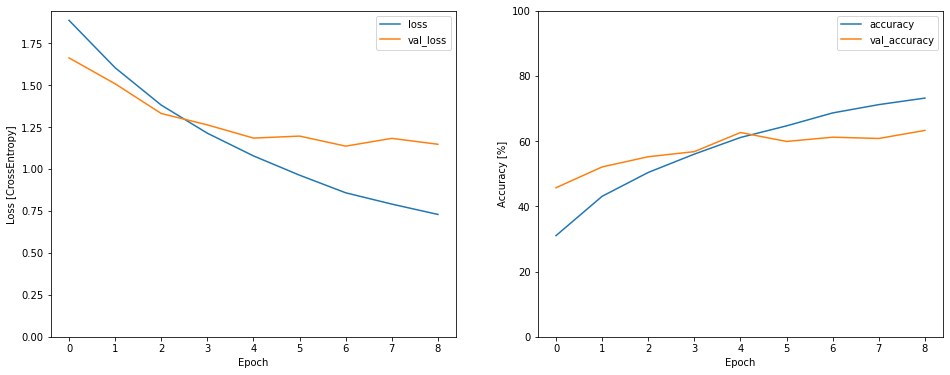

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [ ]:
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 1s 80ms/step - loss: 1.1579 - accuracy: 0.6310


{'loss': 1.1578724384307861, 'accuracy': 0.6310096383094788}

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [ ]:
y_pred = model.predict(test_spectrogram_ds)

13/13 [==============================] - 0s 4ms/step


In [ ]:
y_pred = tf.argmax(y_pred, axis=1)

In [ ]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

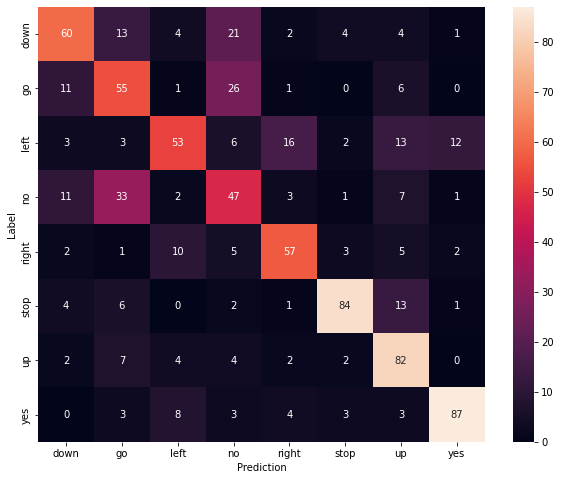

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

In [ ]:
def get_random_audio_file(samples_dir):
  files = os.path.abspath(os.path.join(samples_dir, '*/*.wav'))
  files_list = glob.glob(files)
  random_audio_path = random.choice(files_list)
  return random_audio_path

The data file path: /content/data/mini_speech_commands/left/21832144_nohash_3.wav


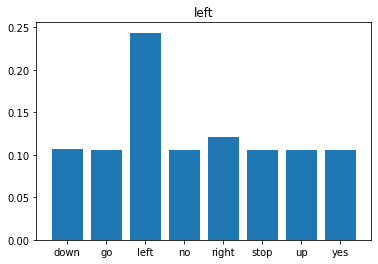

In [ ]:
# x = data_dir/'right/037c445a_nohash_0.wav'
x = get_random_audio_file(data_dir)
print(f"The data file path: {x}")
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
# print(f"Prediction: {prediction[0]}")
x_labels = label_names
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
pred_list = list(prediction[0])
title_str = label_names[pred_list.index(max(pred_list))]
plt.title(title_str)
plt.show()

display.display(display.Audio(waveform, rate=16000))

As the output suggests, your model should have recognized the audio command as "no".

## Export the model with preprocessing

The model's not very easy to use if you have to apply those preprocessing steps before passing data to the model for inference. So build an end-to-end version:

In [ ]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]
    
    x = get_spectrogram(x)  
    result = self.model(x, training=False)
    
    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

Test run the "export" model:

In [ ]:
export = ExportModel(model)
export(tf.constant(str(data_dir/'no/01bb6a2a_nohash_0.wav')))

{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[0.09371833, 0.3436512 , 0.00812542, 0.50041014, 0.00926619,
         0.01620343, 0.02612364, 0.0025016 ]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}

Save and reload the model, the reloaded model gives identical output:

In [ ]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[1.0523785e-02, 3.0751470e-03, 8.3753514e-01, 4.1195094e-03,
         1.3823327e-01, 1.7207169e-05, 1.9160592e-05, 6.4767334e-03]],
       dtype=float32)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'left'], dtype=object)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([2])>}

(1, 124, 129, 1)


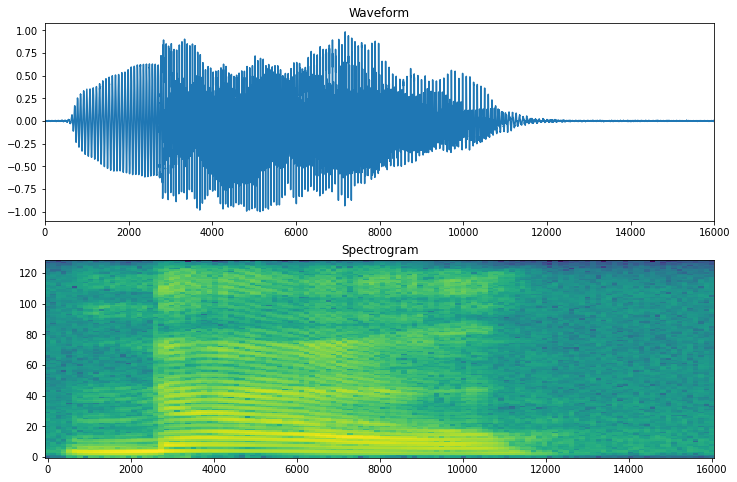

1/1 [==============================] - 0s 73ms/step
[[5.9152422e-03 9.5771208e-02 5.5157153e-07 8.9830565e-01 1.0722270e-08
  6.6545590e-06 2.7460175e-07 4.4814448e-07]]


In [ ]:
x = tf.io.read_file(tf.constant(str(data_dir/'no/0c2ca723_nohash_0.wav')))
x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = x[tf.newaxis, :]
image = get_spectrogram(x)  

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

print(image.numpy().shape)
plot_spectrogram(image.numpy()[0], axes[1])
axes[1].set_title('Spectrogram')
plt.show()
probs = model.predict(image)
print(probs)

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  # signed_grad = tf.sign(gradient)
  # return signed_grad
  return gradient

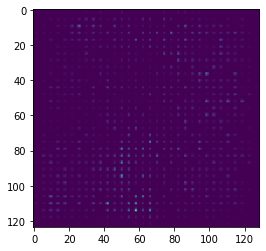

In [ ]:
# Get the input label of the image.
true_label = 3
label = tf.one_hot(true_label, probs.shape[-1])
label = tf.reshape(label, (1, probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
# result = get_spectrogram(perturbations)
plt.imshow(tf.abs(perturbations)[0]*0.5+0.5)  # To change [-1, 1] to [0,1]

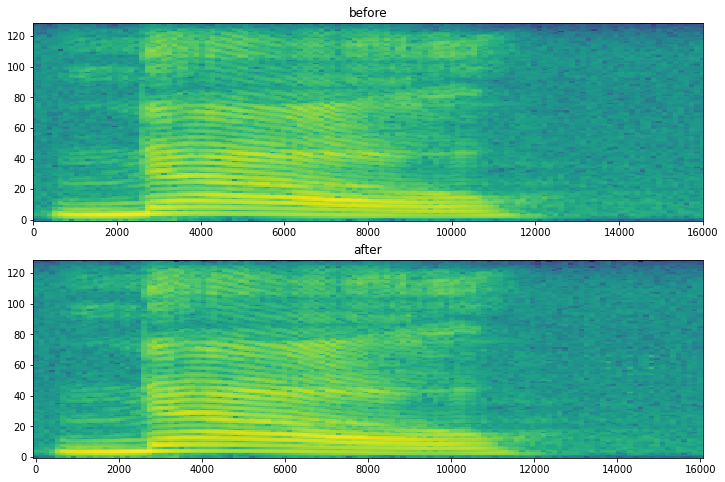

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
plot_spectrogram(image.numpy()[0], axes[0])
axes[0].set_title('before')
axes[0].set_xlim([0, 16000])

wave = tf.signal.inverse_stft(tf.cast(tf.squeeze(image), tf.complex64), frame_length=255, frame_step=128)
display.display(display.Audio(wave, rate=16000))

image2 = image + perturbations * 1
plot_spectrogram(image2.numpy()[0], axes[1])
axes[1].set_title('after')
plt.show()

wave = tf.signal.inverse_stft(tf.cast(tf.squeeze(image2), tf.complex64), frame_length=255, frame_step=128)
display.display(display.Audio(wave, rate=16000))

In [ ]:
def get_label(prediction):
  label = int(tf.argmax(prediction, axis=1))
  return label, prediction[0][label]
def display_images(image, description):
  label, confidence = get_label(model(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

In [ ]:
# success_positive = []
# fail_positive = []
# positive = []
# for i in range(len(example_labels)):
#   print("example",i)
#   true_label = int(example_labels[i])
#   waveform = example_audio[i]
#   spectrogram = get_spectrogram(waveform)
#   spectrogram = spectrogram[tf.newaxis, :]
#   label = tf.one_hot(true_label, probs.shape[-1])
#   label = tf.reshape(label, (1, probs.shape[-1]))
#   perturbations = create_adversarial_pattern(spectrogram, label)
#   # print('Waveform shape:', waveform.shape)
#   # print('Spectrogram shape:', spectrogram.shape)
  
#   # display.display(display.Audio(waveform2, rate=16000))

#   # wave = tf.signal.inverse_stft(tf.cast(tf.squeeze(adv_x), tf.complex64), frame_length=255, frame_step=128)
#   # display.display(display.Audio(wave, rate=16000))

#   fig, axis = plt.subplots(1,1)
#   axis.set_xlim([0, 16000])
#   plot_spectrogram(spectrogram.numpy()[0], axis)
#   plt.show()

#   display.display(display.Audio(waveform, rate=16000))
#   true_label = label_names[true_label]
#   print('true_label:', true_label)
#   predict_label = label_names[int(get_label(model(spectrogram))[0])]
#   print('predict_label:', predict_label)

#   # epsilons = [0,0.01, 0.1,1.0,2.0,5.0]
#   epsilons = [0.1]
#   descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
#                   for eps in epsilons]
  

#   for i, eps in enumerate(epsilons):
#     noise = eps*perturbations
#     noise = tf.cast(tf.clip_by_value(tf.cast(tf.squeeze(noise),tf.double), -1, 1),tf.complex64)
#     noise = noise[tf.newaxis,...,tf.newaxis]
#     adv_x = spectrogram + noise
    

#     adv_wave = tf.signal.inverse_stft(tf.cast(tf.squeeze(adv_x), tf.complex64), frame_length=255, frame_step=128)
#     noise_wave = tf.signal.inverse_stft(tf.cast(tf.squeeze(noise), tf.complex64), frame_length=255, frame_step=128)
#     fig, axis = plt.subplots(1,1)
#     axis.set_xlim([0, 16000])
#     plot_spectrogram(adv_x.numpy()[0], axis)
#     plt.show()

#     display.display(display.Audio(adv_wave, rate=16000))
#     display.display(display.Audio(noise_wave, rate=16000))

#     adversarial_label = label_names[int(get_label(model(adv_x))[0])]
#     print('adversarial_label:', adversarial_label)
#     success_positive.append((predict_label == true_label) and (adversarial_label != predict_label))
#     fail_positive.append(predict_label == true_label and adversarial_label == predict_label)
#     positive.append(predict_label == true_label)
#     # display_images(adv_x, descriptions[i])


In [ ]:
# print(success_positive.count(True)/len(success_positive))
# print(fail_positive.count(True)/len(success_positive))
# print(positive.count(True)/len(success_positive))


NameError: ignored

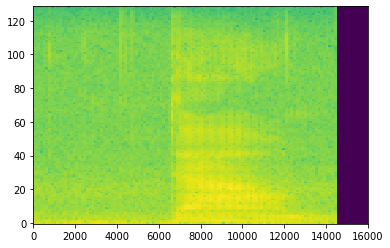

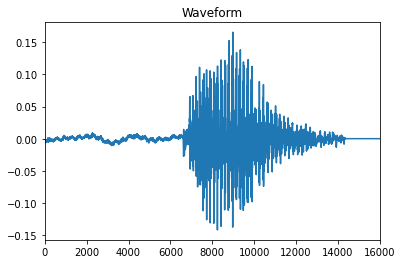

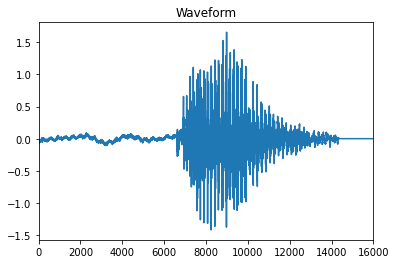

true_label: down
predict_label: down


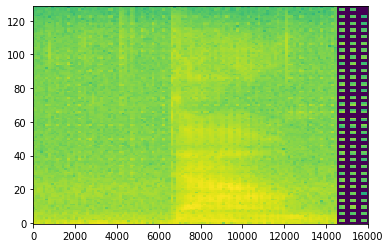

adversarial_label: stop


NameError: ignored

In [ ]:
# fail: 2,4,10
# noisy: 7,8,9,11
i = 9
true_label = int(example_labels[i])
waveform = example_audio[i]
spectrogram = get_spectrogram(waveform)
spectrogram = spectrogram[tf.newaxis, :]
label = tf.one_hot(true_label, probs.shape[-1])
label = tf.reshape(label, (1, probs.shape[-1]))
perturbations = create_adversarial_pattern(spectrogram, label)
# print('Waveform shape:', waveform.shape)
# print('Spectrogram shape:', spectrogram.shape)

# display.display(display.Audio(waveform2, rate=16000))

# wave = tf.signal.inverse_stft(tf.cast(tf.squeeze(adv_x), tf.complex64), frame_length=255, frame_step=128)
# display.display(display.Audio(wave, rate=16000))

fig, axis = plt.subplots(1,1)
axis.set_xlim([0, 16000])

# timescale = np.arange(waveform.shape[0])
# axis.plot(timescale, waveform.numpy())
# plt.show()

plot_spectrogram(spectrogram.numpy()[0], axis)
plt.show()

fig, axis = plt.subplots(1,1)
timescale = np.arange(waveform.shape[0])
axis.plot(timescale, waveform.numpy())
axis.set_title('Waveform')
axis.set_xlim([0, 16000])
plt.show()

display.display(display.Audio(waveform, rate=16000))

waveform1 = tf.identity(waveform)
waveform1 = tf.math.multiply(waveform1, 10)

fig, axis = plt.subplots(1,1)
timescale = np.arange(waveform1.shape[0])
axis.plot(timescale, waveform1.numpy())
axis.set_title('Waveform')
axis.set_xlim([0, 16000])
plt.show()

display.display(display.Audio(waveform1, rate=16000))

true_label = label_names[true_label]
print('true_label:', true_label)
predict_label = label_names[int(get_label(model(spectrogram))[0])]
print('predict_label:', predict_label)

# epsilons = [0,0.01, 0.1,1.0,2.0,5.0]
epsilons = [0.1]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  noise = eps*perturbations
  noise = tf.cast(tf.clip_by_value(tf.cast(tf.squeeze(noise),tf.double), -1, 1),tf.complex64)
  noise = noise[tf.newaxis,...,tf.newaxis]
  adv_x = spectrogram + noise
  

  adv_wave = tf.signal.inverse_stft(tf.cast(tf.squeeze(adv_x), tf.complex64), frame_length=255, frame_step=128)
  noise_wave = tf.signal.inverse_stft(tf.cast(tf.squeeze(noise), tf.complex64), frame_length=255, frame_step=128)
  fig, axis = plt.subplots(1,1)
  axis.set_xlim([0, 16000])

  # timescale = np.arange(adv_wave.shape[0])
  # axis.plot(timescale, adv_wave.numpy())
  # plt.show()

  plot_spectrogram(adv_x.numpy()[0], axis)
  plt.show()

  display.display(display.Audio(adv_wave, rate=16000))
  display.display(display.Audio(noise_wave, rate=16000))

  adversarial_label = label_names[int(get_label(model(adv_x))[0])]
  print('adversarial_label:', adversarial_label)
  # success_positive.append((predict_label == true_label) and (adversarial_label != predict_label))
  fail_positive.append(predict_label == true_label and adversarial_label == predict_label)
  positive.append(predict_label == true_label)
  # display_images(adv_x, descriptions[i])


In [ ]:
!pip install pydub

In [ ]:
from pydub import AudioSegment

def match_target_amplitude(sound, target_dBFS):
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)

sound = AudioSegment.from_file(data_dir/'right/037c445a_nohash_0.wav', "wav") #加载WAV文件
db = sound.dBFS #取得WAV文件的声音分贝值
normalized_sound = match_target_amplitude(sound, db+10) #db+10表示比原来的声音大10db,需要加大音量就加多少，反之则减多少
normalized_sound.export("out.wav", format="wav")

In [ ]:
x1 = tf.io.read_file(tf.constant(str(data_dir/'right/037c445a_nohash_0.wav')))
x1, sample_rate = tf.audio.decode_wav(x1, desired_channels=1, desired_samples=16000,)
waveform1 = tf.squeeze(x1, axis=-1)
display.display(display.Audio(waveform1, rate=16000))

fig, axis = plt.subplots(1,1)
timescale = np.arange(waveform1.shape[0])
axis.plot(timescale, waveform1.numpy())
axis.set_title('Waveform')
axis.set_xlim([0, 16000])
plt.show()

x2 = tf.io.read_file(tf.constant(str("out.wav")))
x2 = tf.io.read_file("out.wav")
x2, sample_rate = tf.audio.decode_wav(x2, desired_channels=1, desired_samples=16000,)
waveform2 = tf.squeeze(x2, axis=-1)

display.display(display.Audio(waveform2, rate=16000))

fig, axis = plt.subplots(1,1)
timescale = np.arange(waveform2.shape[0])
axis.plot(timescale, waveform2.numpy())
axis.set_title('Waveform')
axis.set_xlim([0, 16000])
plt.show()

## Next steps

This tutorial demonstrated how to carry out simple audio classification/automatic speech recognition using a convolutional neural network with TensorFlow and Python. To learn more, consider the following resources:

- The [Sound classification with YAMNet](https://www.tensorflow.org/hub/tutorials/yamnet) tutorial shows how to use transfer learning for audio classification.
- The notebooks from [Kaggle's TensorFlow speech recognition challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/overview).
- The 
[TensorFlow.js - Audio recognition using transfer learning codelab](https://codelabs.developers.google.com/codelabs/tensorflowjs-audio-codelab/index.html#0) teaches how to build your own interactive web app for audio classification.
- [A tutorial on deep learning for music information retrieval](https://arxiv.org/abs/1709.04396) (Choi et al., 2017) on arXiv.
- TensorFlow also has additional support for [audio data preparation and augmentation](https://www.tensorflow.org/io/tutorials/audio) to help with your own audio-based projects.
- Consider using the [librosa](https://librosa.org/) library for music and audio analysis.